In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import plot_importance
import random
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

In [2]:
train = pd.read_csv('../input/train.csv',dtype={'StateHoliday':object}) 
store =  pd.read_csv('../input/store.csv')
test = pd.read_csv('../input/test.csv')

In [3]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)  

### 整理数据

#### 整理test数据

In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
Id               41088 non-null int64
Store            41088 non-null int64
DayOfWeek        41088 non-null int64
Date             41088 non-null object
Open             41077 non-null float64
Promo            41088 non-null int64
StateHoliday     41088 non-null object
SchoolHoliday    41088 non-null int64
dtypes: float64(1), int64(5), object(2)
memory usage: 2.5+ MB


In [5]:
#补充缺失数据
# 特征Open存在数据缺失
# print(test.query('Open=="NaN"'))
#根据Open为NaN的数据展现，由于日期非节假日商店应该都是开门的把NaN替换成1，把0.0变成0，把1.0变成1
test['Open']=test['Open'].fillna(1)
test['Open']=test['Open'].astype(int)
# print(test['Open'].value_counts())
test['Date']=pd.to_datetime(test['Date'])

In [6]:
# 把date拆成year，month和day，重新设置DayOfWeek原因是DayOfWeek比dayofweek多1
test['Year']=test['Date'].dt.year
test['Month']=test['Date'].dt.month
test['Day']=test['Date'].dt.day
test['WeekOfYear']=test['Date'].dt.weekofyear
test['DayOfWeek']=test['Date'].dt.dayofweek
test.drop('Date',axis=1, inplace=True)

In [7]:
#设置StateHoliday a:1,b:2,c:3
test.loc[test["StateHoliday"]=='a','StateHoliday']=1
test.loc[test["StateHoliday"]=='b','StateHoliday']=2
test.loc[test["StateHoliday"]=='c','StateHoliday']=3
test['StateHoliday']=test['StateHoliday'].astype(int)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 11 columns):
Id               41088 non-null int64
Store            41088 non-null int64
DayOfWeek        41088 non-null int64
Open             41088 non-null int32
Promo            41088 non-null int64
StateHoliday     41088 non-null int32
SchoolHoliday    41088 non-null int64
Year             41088 non-null int64
Month            41088 non-null int64
Day              41088 non-null int64
WeekOfYear       41088 non-null int64
dtypes: int32(2), int64(9)
memory usage: 3.1 MB


#### 整理store数据

In [8]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1112 non-null float64
CompetitionOpenSinceMonth    761 non-null float64
CompetitionOpenSinceYear     761 non-null float64
Promo2                       1115 non-null int64
Promo2SinceWeek              571 non-null float64
Promo2SinceYear              571 non-null float64
PromoInterval                571 non-null object
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [13]:
#处理缺失数据
#CompetitionDistance中缺失三条,缺失的数据里同时缺失CompetitionOpenSinceMonth和CompetitionOpenSinceYear，我将其认为在合理距离范围内无竞争对手。
print(store.query('CompetitionDistance=="NaN"')[['Store','CompetitionDistance','CompetitionOpenSinceMonth','CompetitionOpenSinceYear']])
#可以理解为合理范围内没有任何的竞争对手记下Store号码：291，622，879



     Store  CompetitionDistance  CompetitionOpenSinceMonth  \
290    291                  nan                        nan   
621    622                  nan                        nan   
878    879                  nan                        nan   

     CompetitionOpenSinceYear  
290                       nan  
621                       nan  
878                       nan  


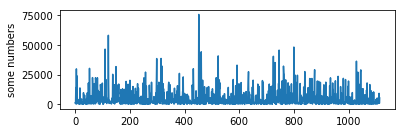

In [19]:
#查看CompetitionDistance的情况
store['CompetitionDistance'].describe()
#根据情况将291，622，879的CompetitionDistance距离改为99999
plt.plot(store['CompetitionDistance'])
plt.ylabel('some numbers')
plt.show()


In [9]:
#处理两个Object字段
#把Assortment整理为a:1,b:2,c:3
store.loc[store["Assortment"]=='a','Assortment']=1
store.loc[store["Assortment"]=='b','Assortment']=2
store.loc[store["Assortment"]=='c','Assortment']=3
store['Assortment']=store['Assortment'].astype(int)
#把StoreType整理为a:1,b:2,c:3,d:4
store.loc[store["StoreType"]=='a','StoreType']=1
store.loc[store["StoreType"]=='b','StoreType']=2
store.loc[store["StoreType"]=='c','StoreType']=3
store.loc[store["StoreType"]=='d','StoreType']=4
store['StoreType']=store['StoreType'].astype(int)

In [5]:
print(store.query('CompetitionDistance=="NaN"'))
#可以理解为合理范围内没有任何的竞争对手记下Store号码：291，622，879
store['CompetitionDistance']=store['CompetitionDistance'].fillna(0)
def f(x):
    return x-int(x)
print(store['CompetitionDistance'].apply(f).value_counts())
# 由于CompetitionDistance所有的小数部分都是0把CompetitionDistance转为int
store['CompetitionDistance']=store['CompetitionDistance'].astype(int)
print(len(store.query('CompetitionOpenSinceMonth=="NaN"&CompetitionOpenSinceYear=="NaN"')))
# 1115-354=761
store.loc[store["CompetitionDistance"]==0,'CompetitionOpenSinceYear']=0
store.loc[store["CompetitionDistance"]==0,'CompetitionOpenSinceMonth']=0

print(min(train['Date']))
print(min(test['Year']))
#训练值里最小的日期是2013-01-01，把没有开业时间的竞争对手店面开店时间随机设置到训练时间之前的随机年份和月份并且改为int型
random.seed(10)
store['CompetitionOpenSinceYear']=store['CompetitionOpenSinceYear'].fillna(random.randint(2002,2012))
store['CompetitionOpenSinceMonth']=store['CompetitionOpenSinceMonth'].fillna(random.randint(1,12))
store['CompetitionOpenSinceYear']=store['CompetitionOpenSinceYear'].astype(int)
store['CompetitionOpenSinceMonth']=store['CompetitionOpenSinceMonth'].astype(int)

print(store['Promo2'].value_counts())
#571说明没有参与促销的商店是571
print(store['Promo2SinceWeek'].value_counts())
print(store['Promo2SinceYear'].value_counts())
store['Promo2SinceWeek']=store['Promo2SinceWeek'].fillna(0)
store['Promo2SinceYear']=store['Promo2SinceYear'].fillna(0)
store['Promo2SinceWeek']=store['Promo2SinceWeek'].astype(int)
store['Promo2SinceYear']=store['Promo2SinceYear'].astype(int)

store.info()

     Store  StoreType  Assortment  CompetitionDistance  \
290    291          4           1                  nan   
621    622          1           3                  nan   
878    879          4           1                  nan   

     CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
290                        nan                       nan       0   
621                        nan                       nan       0   
878                        nan                       nan       1   

     Promo2SinceWeek  Promo2SinceYear    PromoInterval  
290              nan              nan              NaN  
621              nan              nan              NaN  
878            5.000         2013.000  Feb,May,Aug,Nov  
0.000    1115
Name: CompetitionDistance, dtype: int64
354
2013-01-01
2015
1    571
0    544
Name: Promo2, dtype: int64
14.000    81
40.000    77
31.000    44
10.000    42
5.000     39
37.000    35
1.000     35
45.000    34
13.000    34
22.000    33
18.000    29
35.0

In [ ]:
#处理PromoInterval
print(store['PromoInterval'].value_counts())
num_month = {'Jan,Apr,Jul,Oct':'1,4,7,10','Feb,May,Aug,Nov':'2,5,8,11','Mar,Jun,Sept,Dec':'3,6,9,12'}
store['PromoInterval'] =store['PromoInterval'].map(num_month)
store['PromoInterval']=store['PromoInterval'].fillna('0,0,0,0')
store.head()